# Multilabel Document Classification
### Classification of descriptions with Contextual labels: *Stereotype*, *Omission*

In [1]:
import config
import my_utils

# For data analysis
import pandas as pd
import numpy as np
import os, re

# For creating directories
from pathlib import Path

# For word embeddings
from gensim.models import FastText #, Word2Vec
from gensim.utils import tokenize
from gensim import utils
from gensim.test.utils import get_tmpfile

# For preprocessing
import nltk
from nltk.tokenize import word_tokenize

# For classification
import scipy
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import sklearn.metrics
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support

# For saving model
import joblib
from joblib import dump,load

Load the description data.

In [2]:
doc_data = config.exp_data_path+"document_5fold.csv"
df_docs = pd.read_csv(doc_data, index_col=0, converters={"label": lambda x: x.strip("[]").replace("'","").split(", ")})
assert type(df_docs["label"][0]) == list, "The converters should ensure the 'label' column's values are loaded as lists."
df_docs = df_docs.sort_values(by="description_id")
df_docs = df_docs.drop(columns=["subset"])
df_docs.head()

,description_id,start_offset,end_offset,field,description,label,fold
5163,1,17,76,Title,Papers of The Very Rev Prof James Whyte (1920-...,[Stereotype],split2
11541,2,77,633,Scope and Contents,"Sermons and addresses, 1948-1996; lectures, 19...",[],split3
277,3,634,1725,Biographical / Historical,Professor James Aitken White was a leading Sco...,[Stereotype],split4
19301,5,17,60,Title,Papers of Rev Tom Allan (1916-1965),[],split1
21645,6,61,560,Scope and Contents,"Sermons and addresses, 1947-1963; essays and l...",[],split3


Define the training, devtest, and test data splits.

In [3]:
split_col = "fold"
splits = df_docs[split_col].unique()
splits.sort()

# train0, devtest0 = list(splits[:3]), splits[3]
# train1, devtest1 = list(splits[1:4]), splits[0]
# train2, devtest2 = list(splits[2:4])+[splits[0]], splits[1]
# train3, devtest3 = [splits[3]]+list(splits[:2]), splits[2]
# runs = [(train0, devtest0), (train1, devtest1), (train2, devtest2), (train3, devtest3)]
# test = splits[4]
# print(runs)
# print(test)

split_col = "fold"
splits = df_docs[split_col].unique()
splits.sort()
print(splits)
train0, devtest0 = list(splits[:4]), splits[4]
train1, devtest1 = list(splits[1:]), splits[0]
train2, devtest2 = list(splits[2:])+[splits[0]], splits[1]
train3, devtest3 = list(splits[3:])+list(splits[:2]), splits[2]
train4, devtest4 = [splits[4]]+list(splits[:3]), splits[3]
runs = [(train0, devtest0), (train1, devtest1), (train2, devtest2), (train3, devtest3), (train4, devtest4)]
for run in runs:
    print(run)

['split0' 'split1' 'split2' 'split3' 'split4']
(['split0', 'split1', 'split2', 'split3'], 'split4')
(['split1', 'split2', 'split3', 'split4'], 'split0')
(['split2', 'split3', 'split4', 'split0'], 'split1')
(['split3', 'split4', 'split0', 'split1'], 'split2')
(['split4', 'split0', 'split1', 'split2'], 'split3')


Create a binarizer for the Omission and Stereotype labels.

In [4]:
mlb_so = MultiLabelBinarizer()
mlb_so = mlb_so.fit([['Omission', 'Stereotype']])

## 1. Baseline

In [5]:
final_df_devtest = pd.DataFrame()
df = df_docs.copy()
target_col = "label"
pred_col = "predicted"
doc_col = "description"

### 1.1 Baseline Classifier Training and Development

In [6]:
for run in runs:
    print("Run:", run)
    # Select 3 subsets of data as the training set and 1 subset of data as the devtest set
    train_splits, devtest_split = run[0], run[1]
    df_train = df.loc[df[split_col].isin(train_splits)]
    df_devtest = df.loc[df[split_col] == devtest_split]

    # Binarize targets
    y_train = mlb_so.transform(df_train[target_col])
    y_devtest = mlb_so.transform(df_devtest[target_col])

    # Vectorize the documents (descriptions)
    cvectorizer = CountVectorizer()
    tfidf = TfidfTransformer()
    train_docs = cvectorizer.fit_transform(df_train[doc_col])
    devtest_docs = cvectorizer.transform(df_devtest[doc_col])
    X_train = tfidf.fit_transform(train_docs)
    X_devtest = tfidf.transform(devtest_docs)
    
    # Train a classifier
    clf = OneVsRestClassifier(SGDClassifier(loss="hinge"))  # Use Support Vector Machines (SVM) loss function
    clf.fit(X_train, y_train)
    
    # Classify the devtest data with the trained classifier
    y_pred = clf.predict(X_devtest)

    # Format the predicted tags as lists to match the format of the expected tags
    pred_labels = mlb_so.inverse_transform(y_pred)
    new_preds = []
    for labels in pred_labels:
        new_preds += [list(labels)]
    
    # Add the predictions to the devtest DataFrame
    df_devtest.insert(len(df.columns), pred_col, new_preds)

    # Merge any previous devtest DataFrames with the latest devtest DataFrame
    final_df_devtest = pd.concat([final_df_devtest, df_devtest])

# assert final_df_devtest.shape[0] < df.shape[0]
final_df_devtest.predicted.value_counts()

Run: (['split0', 'split1', 'split2', 'split3'], 'split4')


/Users/lucyhavens/miniconda3/envs/gender-bias-env/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) [''] will be ignored
  warnings.warn(


Run: (['split1', 'split2', 'split3', 'split4'], 'split0')


/Users/lucyhavens/miniconda3/envs/gender-bias-env/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) [''] will be ignored
  warnings.warn(


Run: (['split2', 'split3', 'split4', 'split0'], 'split1')


/Users/lucyhavens/miniconda3/envs/gender-bias-env/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) [''] will be ignored
  warnings.warn(


Run: (['split3', 'split4', 'split0', 'split1'], 'split2')


/Users/lucyhavens/miniconda3/envs/gender-bias-env/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) [''] will be ignored
  warnings.warn(


Run: (['split4', 'split0', 'split1', 'split2'], 'split3')


/Users/lucyhavens/miniconda3/envs/gender-bias-env/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) [''] will be ignored
  warnings.warn(


[]                        24398
[Omission]                 1644
[Omission, Stereotype]      900
[Stereotype]                370
Name: predicted, dtype: int64

In [7]:
final_df_devtest.head()

,description_id,start_offset,end_offset,field,description,label,fold,predicted
277,3,634,1725,Biographical / Historical,Professor James Aitken White was a leading Sco...,[Stereotype],split4,[Stereotype]
20188,10,77,417,Scope and Contents,"Academic papers, 1942-1986; publications and a...",[],split4,[]
6748,19,268,294,Title,Commonplace Book 2,[],split4,[]
24617,28,540,556,Title,Notebook,[],split4,[]
6873,30,581,609,Title,Poems and quotations,[],split4,[]


In [8]:
y_devtest = mlb_so.transform(final_df_devtest[target_col])
y_pred = mlb_so.transform(final_df_devtest[pred_col])

/Users/lucyhavens/miniconda3/envs/gender-bias-env/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) [''] will be ignored
  warnings.warn(


In [9]:
# pred_dir = "data/multilabel_doc_predictions/baseline/"
pred_dir = "data/multilabel_doc_predictions/baseline/mod5fold/"
Path(pred_dir).mkdir(parents=True, exist_ok=True)
# final_df_devtest.to_csv(pred_dir+"svm_tfidf_devtest_predictions.csv")
final_df_devtest.to_csv(pred_dir+"svm_tfidf_predictions.csv")

In [50]:
matrix = multilabel_confusion_matrix(y_devtest, y_pred, labels=clf.classes_)

tn = matrix[:, 0, 0]  # True negatives
fp = matrix[:, 1, 0]  # False negatives - positives?
tp = matrix[:, 1, 1]  # True positives
fn = matrix[:, 0, 1]  # False positives - negatives?
class_names = list(mlb_so.classes_)

[precision, recall, f_1, suport] = precision_recall_fscore_support(
    y_devtest, y_pred, beta=1.0, zero_division=0, labels=clf.classes_
)

baseline_agmt_df = pd.DataFrame({
    "labels":class_names, "true_neg":tn, "false_neg":fn, "true_pos":tp, "false_pos":fp,
    "precision":precision, "recall":recall, "f_1":f_1
})
baseline_agmt_df

,labels,true_neg,false_neg,true_pos,false_pos,precision,recall,f_1
0,Omission,22922,358,2186,1846,0.859277,0.542163,0.664842
1,Stereotype,25634,77,1193,408,0.939370,0.745159,0.831069


In [41]:
mcm = multilabel_confusion_matrix(y_devtest, y_pred)
print(mcm)

[[[22922   358]
  [ 1846  2186]]

 [[25634    77]
  [  408  1193]]]


In [49]:
mcm[:, 0, 1] 

array([358,  77])

In [38]:
print(clf.classes_, mlb_so.classes_)

[0 1] ['Omission' 'Stereotype']


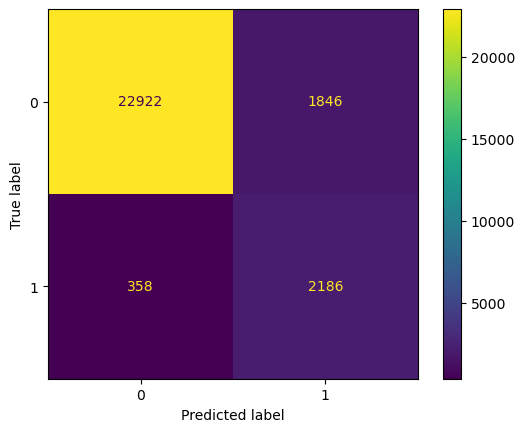

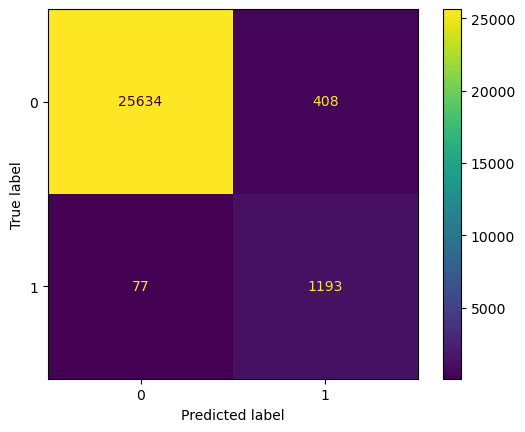

In [ ]:
matrices = dict()  # keys are labels, values are 2D arrays 
for col in range(len(clf.classes_)):
    y_test_label = y_devtest[:, col]
    pred_label = y_pred[:, col]
    
    matrices[clf.classes_[col]] = confusion_matrix(pred_label, y_test_label)#, normalize="all")

ConfusionMatrixDisplay(matrices[0], display_labels=["Not Omission","Omission"]).plot()
ConfusionMatrixDisplay(matrices[0], display_labels=["Not Stereotype","Stereotype"]).plot()

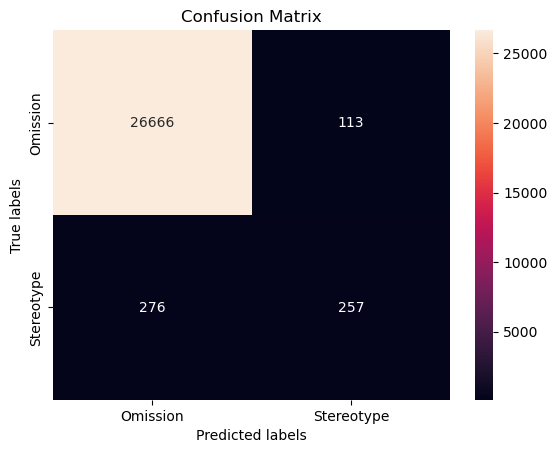

In [39]:
import seaborn as sns

labels = mlb_so.classes_    

ax= plt.subplot()

cm = confusion_matrix(np.asarray(y_devtest).argmax(axis=1), np.asarray(y_pred).argmax(axis=1))
# cm = confusion_matrix(y_devtest, y_pred)
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);


### 1.2 Testing

In [11]:
# Fit vectorizers to training data
cvectorizer = CountVectorizer()
tfidf = TfidfTransformer()
train_docs = cvectorizer.fit_transform(df_train[doc_col])
train_docs = tfidf.fit_transform(train_docs)

# Transform test data
df_test = df.loc[df[split_col] == test]
y_test = mlb_so.transform(df_test[target_col])
test_docs = cvectorizer.transform(df_test[doc_col])
X_test = tfidf.transform(test_docs)

# Classify the test data
y_pred = clf.predict(X_test)

/Users/lucyhavens/miniconda3/envs/gender-bias-env/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) [''] will be ignored
  warnings.warn(


In [12]:
# Format the predicted tags as lists to match the format of the expected tags
pred_labels = mlb_so.inverse_transform(y_pred)
new_preds = []
for labels in pred_labels:
    new_preds += [list(labels)]

Export the data with predicted labels:

In [13]:
df_test.insert(len(df.columns), pred_col, new_preds)
df_test.head()

,description_id,start_offset,end_offset,field,description,label,fold,predicted
277,3,634,1725,Biographical / Historical,Professor James Aitken White was a leading Sco...,[Stereotype],split4,[Stereotype]
20188,10,77,417,Scope and Contents,"Academic papers, 1942-1986; publications and a...",[],split4,[]
6748,19,268,294,Title,Commonplace Book 2,[],split4,[]
24617,28,540,556,Title,Notebook,[],split4,[]
6873,30,581,609,Title,Poems and quotations,[],split4,[]


In [14]:
df_test[pred_col].value_counts()

[]                        4822
[Omission]                 361
[Omission, Stereotype]     184
[Stereotype]                97
Name: predicted, dtype: int64

In [15]:
df_test.to_csv(pred_dir+"svm_tfidf_test_predictions.csv")

In [16]:
matrix = multilabel_confusion_matrix(y_test, y_pred, labels=clf.classes_)

tn = matrix[:, 0, 0]  # True negatives
fn = matrix[:, 1, 0]  # False negatives
tp = matrix[:, 1, 1]  # True positives
fp = matrix[:, 0, 1]  # False positives
class_names = list(mlb_so.classes_)

[precision, recall, f_1, suport] = precision_recall_fscore_support(
    y_test, y_pred, beta=1.0, zero_division=0, labels=clf.classes_
)

test_agmt_df = pd.DataFrame({
    "labels":class_names, "true_neg":tn, "false_neg":fn, "true_pos":tp, "false_pos":fp,
    "precision":precision, "recall":recall, "f_1":f_1
})
test_agmt_df

,labels,true_neg,false_neg,true_pos,false_pos,precision,recall,f_1
0,Omission,4540,379,459,86,0.842202,0.547733,0.663774
1,Stereotype,5107,76,267,14,0.950178,0.778426,0.855769


Export the models:

In [17]:
model_dir = config.models_path+"multilabel_document/"
Path(model_dir).mkdir(parents=True, exist_ok=True)

# Save baseline classifier
filename = model_dir+"sgd-svm_F-tfidf_T-os.joblib"  # include features (F) and targets (T) in model's file name
dump(clf, filename)
print("Saved", filename)

# Save multilabel binarizer for Stereotype and Omission labels
filename = model_dir+"mlb_targets_os.joblib"
dump(mlb_so, filename)
print("Saved", filename)

# Save the Count Vectorizer
filename = model_dir+"count_vectorizer.joblib"
dump(cvectorizer, filename)
print("Saved", filename)

# Save the Term Frequency Inverse Document Frequency (TFIDF) transformer
filename = model_dir+"tfidf_transformer.joblib"
dump(tfidf, filename)
print("Saved", filename)

Saved models/multilabel_document/sgd-svm_F-tfidf_T-os.joblib
Saved models/multilabel_document/mlb_targets_os.joblib
Saved models/multilabel_document/count_vectorizer.joblib
Saved models/multilabel_document/tfidf_transformer.joblib


## 2. Experiment 2, Model 2
### 2.1 Data Preprocessing

Load data from multilabel token classification of **Linguistic** labels:

In [5]:
pred_dir = "data/multilabel_token_predictions/ccrf_ftcbow100lower/"
ling_clf_output = pred_dir+"ccrf_ftcbow100_alldata_predictions.csv"
df_features = pd.read_csv(ling_clf_output, index_col=0)
df_features.head()

,description_id,sentence_id,token_id,token,pos,field,token_offsets,tag,fold,predicted,_merge
0,0,0,0,Identifier,NN,Identifier,"(0, 10)",O,split4,O,true negative
1,0,0,1,:,:,Identifier,"(10, 11)",O,split4,O,true negative
2,0,0,2,AA5,NN,Identifier,"(12, 15)",O,split4,O,true negative
3,3,4,134,He,PRP,Biographical / Historical,"(789, 791)",Gendered-Pronoun,split4,Gendered-Pronoun,true positive
4,3,4,135,was,VBD,Biographical / Historical,"(792, 795)",O,split4,O,true negative


In [ ]:
# Group the data by description so it can be combined with the description data
df_features = my_utils.implodeDataFrameUnique(df_features[["description_id", "sentence_id", "token_id", "predicted"]], ["description_id"])

# Deduplicate lists in sentence_id, token_id, and predicted columns
cols = ["sentence_id", "token_id", "predicted"]
for col in cols:
    old_col = list(df_features[col])
    # dedup_col = [list(set(values)) for values in old_col]
    new_col = []
    if col == "predicted":
        for values in old_col:
            if (len(values) > 1) and ("O" in values):
                values.remove("O")
            new_col += [list(values)]
    else:
        new_col = old_col
    col_i = list(df_features.columns).index(col)
    df_features = df_features.drop(columns=[col])
    df_features.insert(col_i, col, new_col)

df_features.head()

,sentence_id,token_id,predicted
description_id,,,
0,[0],"[0, 1, 2]",[O]
1,[1],"[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]",[O]
2,[2],"[16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 2...",[O]
3,"[3, 4, 5, 6, 7, 8, 9, 10]","[109, 110, 111, 112, 113, 114, 115, 116, 117, ...","[O, Gendered-Pronoun]"
4,[11],"[308, 309, 310]",[O]


### 2.2 Feature Extraction

Join the feature data (i.e. classifier-predicted **Linguistic** labels) to the document data (i.e. catalog metadata descriptions):

In [ ]:
df = df_features.join(df_docs.set_index("description_id"), on="description_id", how="right")

# Rename label columns for clarity
df = df.rename(columns={"predicted":"linguistic_pred", "label":"exp_label"})

# # Remove "O" from linguistic prediction lists if other labels are present in the list
# ling_pred = list(df["linguistic_pred"])
# new_ling_pred = []
# for pred in ling_pred:
#     if len(pred) > 1:
#         if "O" in pred:
#             pred.remove("O")
#     new_ling_pred += [pred]

df = df.drop(columns=["linguistic_pred"])
df.insert(3, "linguistic_pred", new_ling_pred)
df.head()

,sentence_id,token_id,start_offset,linguistic_pred,end_offset,field,description,exp_label,fold
description_id,,,,,,,,,
1,[1],"[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]",17,[O],76,Title,Papers of The Very Rev Prof James Whyte (1920-...,[Stereotype],split2
2,[2],"[16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 2...",77,[O],633,Scope and Contents,"Sermons and addresses, 1948-1996; lectures, 19...",[],split3
3,"[3, 4, 5, 6, 7, 8, 9, 10]","[109, 110, 111, 112, 113, 114, 115, 116, 117, ...",634,[Gendered-Pronoun],1725,Biographical / Historical,Professor James Aitken White was a leading Sco...,[Stereotype],split4
5,[12],"[320, 311, 312, 313, 314, 315, 316, 317, 318, ...",17,[O],60,Title,Papers of Rev Tom Allan (1916-1965),[],split1
6,"[13, 14]","[321, 322, 323, 324, 325, 326, 327, 328, 329, ...",61,[O],560,Scope and Contents,"Sermons and addresses, 1947-1963; essays and l...",[],split3


In [21]:
df.linguistic_pred.value_counts()

[O]                                                  20758
[Gendered-Role]                                        863
[Gendered-Pronoun]                                     657
[Gendered-Pronoun, Gendered-Role]                      345
[Generalization]                                       116
[Gendered-Pronoun, Gendered-Role, Generalization]       73
[Gendered-Pronoun, Generalization]                      47
[Gendered-Role, Generalization]                         32
Name: linguistic_pred, dtype: int64

### 2.3 Classifier Training and Development

In [9]:
mlb_ling = joblib.load(config.models_path+"multilabel_token/mlb_targets_ling.joblib")

In [10]:
mlb_ling.classes_

array(['Gendered-Pronoun', 'Gendered-Role', 'Generalization'],
      dtype=object)

In [11]:
mlb_so.classes_

array(['Omission', 'Stereotype'], dtype=object)

In [12]:
final_df_devtest = pd.DataFrame()
feat_col = "linguistic_pred"
target_col = "exp_label"
for run in runs:
    print("Run:", run)
    # Select 3 subsets of data as the training set and 1 subset of data as the devtest set
    train_splits, devtest_split = run[0], run[1]
    df_train = df.loc[df[split_col].isin(train_splits)]
    df_devtest = df.loc[df[split_col] == devtest_split]

    # Binarize the features
    train_feat = mlb_ling.transform(df_train[feat_col])
    devtest_feat = mlb_ling.transform(df_devtest[feat_col])

    # Binarize targets
    y_train = mlb_so.transform(df_train[target_col])
    y_devtest = mlb_so.transform(df_devtest[target_col])

    # Vectorize the documents (descriptions)
    cvectorizer = CountVectorizer()
    tfidf = TfidfTransformer()
    doc_col = "description"
    train_docs = cvectorizer.fit_transform(df_train[doc_col])
    devtest_docs = cvectorizer.transform(df_devtest[doc_col])
    train_docs = tfidf.fit_transform(train_docs)
    devtest_docs = tfidf.transform(devtest_docs)

    # Concatenate the features and documents
    X_train = scipy.sparse.hstack([train_docs, train_feat])
    X_devtest = scipy.sparse.hstack([devtest_docs, devtest_feat])
    
    # Train a classifier
    clf = OneVsRestClassifier(SGDClassifier(loss="hinge"))  # Use Support Vector Machines (SVM) loss function
    clf.fit(X_train, y_train)
    
    # Classify the devtest data with the trained classifier
    y_pred = clf.predict(X_devtest)

    # Format the predicted tags as lists to match the format of the expected tags
    pred_labels = mlb_so.inverse_transform(y_pred)
    new_preds = []
    for labels in pred_labels:
        new_preds += [list(labels)]
    
    # Add the predictions to the devtest DataFrame
    df_devtest.insert(len(df.columns), "predicted", new_preds)

    # Merge any previous devtest DataFrames with the latest devtest DataFrame
    final_df_devtest = pd.concat([final_df_devtest, df_devtest])

assert final_df_devtest.shape[0] < df.shape[0]
final_df_devtest.predicted.value_counts()

Run: (['split0', 'split1', 'split2'], 'split3')


/Users/lucyhavens/miniconda3/envs/gender-bias-env/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['O'] will be ignored
  warnings.warn(
/Users/lucyhavens/miniconda3/envs/gender-bias-env/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) [''] will be ignored
  warnings.warn(


Run: (['split1', 'split2', 'split3'], 'split0')


/Users/lucyhavens/miniconda3/envs/gender-bias-env/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['O'] will be ignored
  warnings.warn(
/Users/lucyhavens/miniconda3/envs/gender-bias-env/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) [''] will be ignored
  warnings.warn(


Run: (['split2', 'split3', 'split0'], 'split1')
Run: (['split3', 'split0', 'split1'], 'split2')


/Users/lucyhavens/miniconda3/envs/gender-bias-env/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['O'] will be ignored
  warnings.warn(
/Users/lucyhavens/miniconda3/envs/gender-bias-env/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) [''] will be ignored
  warnings.warn(
/Users/lucyhavens/miniconda3/envs/gender-bias-env/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['O'] will be ignored
  warnings.warn(
/Users/lucyhavens/miniconda3/envs/gender-bias-env/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) [''] will be ignored
  warnings.warn(


[]                        19220
[Omission]                 1588
[Omission, Stereotype]      743
[Stereotype]                297
Name: predicted, dtype: int64

In [13]:
final_df_devtest.head()

,sentence_id,token_id,start_offset,linguistic_pred,end_offset,field,description,exp_label,fold,predicted
description_id,,,,,,,,,,
2,[2],"[16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 2...",77,[O],633,Scope and Contents,"Sermons and addresses, 1948-1996; lectures, 19...",[],split3,[]
6,"[13, 14]","[321, 322, 323, 324, 325, 326, 327, 328, 329, ...",61,[O],560,Scope and Contents,"Sermons and addresses, 1947-1963; essays and l...",[],split3,[]
14,[48],"[1216, 1217, 1218, 1219, 1220, 1215]",85,[O],115,Title,Papers of John Baillie,[],split3,[]
15,[49],"[1221, 1222, 1223, 1224, 1225]",116,[O],143,Title,Notes and notebooks,[],split3,[]
16,[50],"[1226, 1227, 1228, 1229, 1230, 1231, 1232, 123...",144,[O],210,Title,Poems chiefly from lesser authors selected by ...,[Omission],split3,[]


In [14]:
y_devtest = mlb_so.transform(final_df_devtest["exp_label"])
y_pred = mlb_so.transform(final_df_devtest["predicted"])

/Users/lucyhavens/miniconda3/envs/gender-bias-env/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) [''] will be ignored
  warnings.warn(


In [15]:
matrix = multilabel_confusion_matrix(y_devtest, y_pred, labels=clf.classes_)

tn = matrix[:, 0, 0]  # True negatives
fn = matrix[:, 1, 0]  # False negatives
tp = matrix[:, 1, 1]  # True positives
fp = matrix[:, 0, 1]  # False positives
class_names = list(mlb_so.classes_)

[precision, recall, f_1, suport] = precision_recall_fscore_support(
    y_devtest, y_pred, beta=1.0, zero_division=0, labels=clf.classes_
)

agmt_df = pd.DataFrame({
    "labels":class_names, "true_neg":tn, "false_neg":fn, "true_pos":tp, "false_pos":fp,
    "precision":precision, "recall":recall, "f_1":f_1
})
agmt_df

,labels,true_neg,false_neg,true_pos,false_pos,precision,recall,f_1
0,Omission,18217,1300,1894,437,0.812527,0.592987,0.685611
1,Stereotype,20509,299,959,81,0.922115,0.762321,0.834639


### 2.4 Testing

In [16]:
# Fit vectorizers to training data
cvectorizer = CountVectorizer()
tfidf = TfidfTransformer()
doc_col = "description"
train_docs = cvectorizer.fit_transform(df_train[doc_col])
train_docs = tfidf.fit_transform(train_docs)

# Transform test data
df_test = df.loc[df[split_col] == test]
test_feat = mlb_ling.transform(df_test[feat_col])
y_test = mlb_so.transform(df_test[target_col])
test_docs = cvectorizer.transform(df_test[doc_col])
test_docs = tfidf.transform(test_docs)
X_test = scipy.sparse.hstack([test_docs, test_feat])

# Classify the test data
y_pred = clf.predict(X_test)

/Users/lucyhavens/miniconda3/envs/gender-bias-env/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['O'] will be ignored
  warnings.warn(
/Users/lucyhavens/miniconda3/envs/gender-bias-env/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) [''] will be ignored
  warnings.warn(


In [17]:
# Format the predicted tags as lists to match the format of the expected tags
pred_labels = mlb_so.inverse_transform(y_pred)
new_preds = []
for labels in pred_labels:
    new_preds += [list(labels)]
print(new_preds[100:200])

[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], ['Omission', 'Stereotype'], [], [], [], ['Omission', 'Stereotype'], [], [], [], ['Omission', 'Stereotype'], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], ['Omission'], [], ['Omission', 'Stereotype'], [], [], [], [], [], [], [], [], ['Omission'], ['Omission'], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], ['Stereotype'], [], ['Omission', 'Stereotype'], [], []]


Export the data with predicted labels:

In [18]:
df_test.insert(len(df.columns), "predicted", new_preds)
df_test.head()

,sentence_id,token_id,start_offset,linguistic_pred,end_offset,field,description,exp_label,fold,predicted
description_id,,,,,,,,,,
3,"[3, 4, 5, 6, 7, 8, 9, 10]","[109, 110, 111, 112, 113, 114, 115, 116, 117, ...",634,[Gendered-Pronoun],1725,Biographical / Historical,Professor James Aitken White was a leading Sco...,[Stereotype],split4,[]
10,[31],"[780, 781, 782, 783, 784, 785, 786, 787, 788, ...",77,[O],417,Scope and Contents,"Academic papers, 1942-1986; publications and a...",[],split4,[]
19,[53],"[1248, 1249, 1250, 1251, 1252]",268,[O],294,Title,Commonplace Book 2,[],split4,[]
28,[62],"[1296, 1294, 1295]",540,[O],556,Title,Notebook,[],split4,[]
30,[64],"[1301, 1302, 1303, 1304, 1305]",581,[O],609,Title,Poems and quotations,[],split4,[]


In [19]:
df_test["predicted"].value_counts()

[]                        4748
[Omission]                 433
[Omission, Stereotype]     188
[Stereotype]                95
Name: predicted, dtype: int64

Save the test predictions:

In [20]:
pred_dir = "data/multilabel_doc_predictions/ling_features_dedup/" # max. of one of each Linguistic label per description (no duplicates)
Path(pred_dir).mkdir(parents=True, exist_ok=True)
df_test.to_csv(pred_dir+"svm_tfidf-ling_test_predictions.csv")

In [21]:
matrix = multilabel_confusion_matrix(y_test, y_pred, labels=clf.classes_)

tn = matrix[:, 0, 0]  # True negatives
fn = matrix[:, 1, 0]  # False negatives
tp = matrix[:, 1, 1]  # True positives
fp = matrix[:, 0, 1]  # False positives
class_names = list(mlb_so.classes_)

[precision, recall, f_1, suport] = precision_recall_fscore_support(
    y_test, y_pred, beta=1.0, zero_division=0, labels=clf.classes_
)

test_agmt_df = pd.DataFrame({
    "labels":class_names, "true_neg":tn, "false_neg":fn, "true_pos":tp, "false_pos":fp,
    "precision":precision, "recall":recall, "f_1":f_1
})
test_agmt_df

,labels,true_neg,false_neg,true_pos,false_pos,precision,recall,f_1
0,Omission,4503,340,498,123,0.801932,0.594272,0.682659
1,Stereotype,5108,73,270,13,0.954064,0.787172,0.862620


Export the models:

In [22]:
model_dir = config.models_path+"multilabel_document/"
Path(model_dir).mkdir(parents=True, exist_ok=True)

# Save classifier
filename = model_dir+"sgd-svm_F-tfidf-ling_T-os.joblib"  # include features (F) and targets (T) in model's file name
dump(clf, filename)
print("Saved", filename)

# # Save multilabel binarizer for Stereotype and Omission labels
# filename = model_dir+"mlb_targets_os.joblib"
# dump(mlb_so, filename)
# print("Saved", filename)

# # Save the Count Vectorizer
# filename = model_dir+"count_vectorizer.joblib"
# dump(cvectorizer, filename)
# print("Saved", filename)

# # Save the Term Frequency Inverse Document Frequency (TFIDF) transformer
# filename = model_dir+"tfidf_transformer.joblib"
# dump(tfidf, filename)
# print("Saved", filename)

Saved models/multilabel_document/sgd-svm_F-tfidf-ling_T-os.joblib
